In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

folder_path = "/content/drive/MyDrive/Nour/twitter"
print(f"Working with folder: {folder_path}")

Working with folder: /content/drive/MyDrive/Nour/twitter


In [ ]:
import pandas as pd
csv_path= os.path.join(folder_path, "twitter_tsonduku.csv")
twitter_df=pd.read_csv(csv_path)

/tmp/ipython-input-45-407290648.py:3: DtypeWarning: Columns (9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  twitter_df=pd.read_csv(csv_path)


In [ ]:
twitter_df.columns

Index(['id', 'text', 'created_at', 'lang', 'entities.urls',
       'entities.user_mentions', 'entities.hashtags', 'user.id',
       'user.description', 'user.location', 'user.name', 'user.screen_name',
       'user.url', 'user.protected', 'user.verified', 'user.followers_count',
       'user.friends_count', 'user.listed_count', 'user.favourites_count',
       'user.statuses_count', 'user.created_at',
       'user.profile_image_url_https', 'user.default_profile',
       'user.default_profile_image', 'is_retweet', 'is_quote', 'is_reply',
       'in_reply_to_user_id', 'in_reply_to_status_id', 'quote.id',
       'quote.user.id', 'rt.id', 'rt.user.id', 'user.type'],
      dtype='object')

In [ ]:
len(twitter_df)

1716726

In [ ]:
len(twitter_df['user.verified'])

1716726

In [ ]:
twitter_df['user.type'].unique()

array(['bot', 'deleted', 'suspended', 'other'], dtype=object)

# **Data preparation**

In [ ]:
import pandas as pd


twitter_df = twitter_df[~twitter_df['user.type'].isin(['deleted', 'suspended'])].copy()


twitter_df = twitter_df[twitter_df['user.type'].isin(['bot', 'other'])].copy()


user_df = twitter_df.drop_duplicates(subset='user.id')[['user.id', 'user.type']].copy()


total_users = len(user_df)
n_labeled = int(0.8 * total_users)


bots = user_df[user_df['user.type'] == 'bot']
humans = user_df[user_df['user.type'] == 'other']


n_bots = int(0.5 * n_labeled)
n_humans = n_labeled - n_bots


n_bots = min(n_bots, len(bots))
n_humans = min(n_humans, len(humans))
n_labeled = n_bots + n_humans


labeled_bots = bots.sample(n=n_bots, random_state=42)
labeled_humans = humans.sample(n=n_humans, random_state=42)



labeled_users = pd.concat([labeled_bots, labeled_humans])
labeled_users['final_label'] = labeled_users['user.type']


unlabeled_users = user_df.drop(index=labeled_users.index)
unlabeled_users['final_label'] = 'unknown'


final_user_labels = pd.concat([labeled_users, unlabeled_users], ignore_index=True)


twitter_df = twitter_df.merge(final_user_labels[['user.id', 'final_label']], on='user.id', how='left')
twitter_df['user.type'] = twitter_df['final_label']
twitter_df.drop(columns=['final_label'], inplace=True)


print(twitter_df['user.type'].value_counts(normalize=True))


user.type
unknown    0.452472
other      0.355057
bot        0.192470
Name: proportion, dtype: float64


# **Features building**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

def extract_combined_features(twitter_df):
    REFERENCE_DATE = datetime(2021, 7, 8)


    twitter_df["user.created_at"] = pd.to_datetime(twitter_df["user.created_at"], errors='coerce')
    twitter_df["created_at"] = pd.to_datetime(twitter_df["created_at"], errors='coerce')


    user_meta = twitter_df.drop_duplicates("user.id").copy()
    user_meta["user.created_at"] = user_meta["user.created_at"].dt.tz_localize(None)
    user_meta["account_age_days"] = (REFERENCE_DATE - user_meta["user.created_at"]).dt.days.clip(lower=1)



    user_meta["followers_per_day"] = user_meta["user.followers_count"] / user_meta["account_age_days"]
    user_meta["friends_per_day"] = user_meta["user.friends_count"] / user_meta["account_age_days"]
    user_meta["statuses_per_day"] = user_meta["user.statuses_count"] / user_meta["account_age_days"]
    user_meta["listed_per_day"] = user_meta["user.listed_count"] / user_meta["account_age_days"]
    user_meta["follow_ratio"] = user_meta["user.friends_count"] / (user_meta["user.followers_count"] + 1)


    user_meta["n_digits_username"] = user_meta["user.screen_name"].astype(str).apply(lambda x: sum(c.isdigit() for c in x))
    user_meta["has_url"] = user_meta["user.url"].notnull().astype(int)
    user_meta["has_location"] = user_meta["user.location"].notnull().astype(int)
    user_meta["verified"] = user_meta["user.verified"].astype(int)


    log_cols = [
        "account_age_days", "user.followers_count", "user.friends_count",
        "user.statuses_count", "user.listed_count", "followers_per_day",
        "friends_per_day", "statuses_per_day", "listed_per_day", "follow_ratio"
    ]
    for col in log_cols:
        user_meta[f"log_{col}"] = np.log1p(user_meta[col])


    twitter_df["date"] = twitter_df["created_at"].dt.date
    tweet_volume = twitter_df.groupby("user.id").agg(
        statuses_count=("id", "count"),
        rts_count=("is_retweet", "sum"),
        quotes_count=("is_quote", "sum"),
        replies_count=("is_reply", "sum"),
        active_days=("date", "nunique")
    )

    tweet_volume["daily_rythm"] = tweet_volume["statuses_count"] / tweet_volume["active_days"]
    tweet_volume = tweet_volume.replace([np.inf, -np.inf], 0).fillna(0)


    volume_log = np.log1p(tweet_volume[["statuses_count", "rts_count", "quotes_count", "replies_count"]])
    volume_norm = volume_log.div(tweet_volume["active_days"], axis=0).add_suffix("_normalized")


    features = (
        user_meta.set_index("user.id")[[
            "n_digits_username", "has_url", "has_location", "verified"
        ] + [f"log_{col}" for col in log_cols]]
        .join(tweet_volume[["active_days", "daily_rythm"]], how="left")
        .join(volume_log.add_prefix("log_"), how="left")
        .join(volume_norm, how="left")
        .fillna(0)
    )

    return features.reset_index()


In [ ]:
features_df = extract_combined_features(twitter_df)
print(features_df.head())

/tmp/ipython-input-48-1148693868.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  twitter_df["user.created_at"] = pd.to_datetime(twitter_df["user.created_at"], errors='coerce')
/tmp/ipython-input-48-1148693868.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  twitter_df["created_at"] = pd.to_datetime(twitter_df["created_at"], errors='coerce')


     user.id  n_digits_username  has_url  has_location  verified  \
0  467108258                  2        0             1         0   
1  691055830                  0        0             1         0   
2  324604086                  2        0             1         0   
3  745737780                  0        0             1         0   
4  188042693                  0        0             1         0   

   log_account_age_days  log_user.followers_count  log_user.friends_count  \
0              6.493754                  8.542081                8.637817   
1              7.149917                 10.932750               10.149644   
2              7.633854                 11.374778               11.364773   
3              7.393263                 11.265784               10.933464   
4              8.238008                 10.948769               10.760644   

   log_user.statuses_count  log_user.listed_count  ...  active_days  \
0                 9.147826               1.609438  ...   

In [ ]:
features_df.columns

Index(['user.id', 'n_digits_username', 'has_url', 'has_location', 'verified',
       'log_account_age_days', 'log_user.followers_count',
       'log_user.friends_count', 'log_user.statuses_count',
       'log_user.listed_count', 'log_followers_per_day', 'log_friends_per_day',
       'log_statuses_per_day', 'log_listed_per_day', 'log_follow_ratio',
       'active_days', 'daily_rythm', 'log_statuses_count', 'log_rts_count',
       'log_quotes_count', 'log_replies_count', 'statuses_count_normalized',
       'rts_count_normalized', 'quotes_count_normalized',
       'replies_count_normalized'],
      dtype='object')

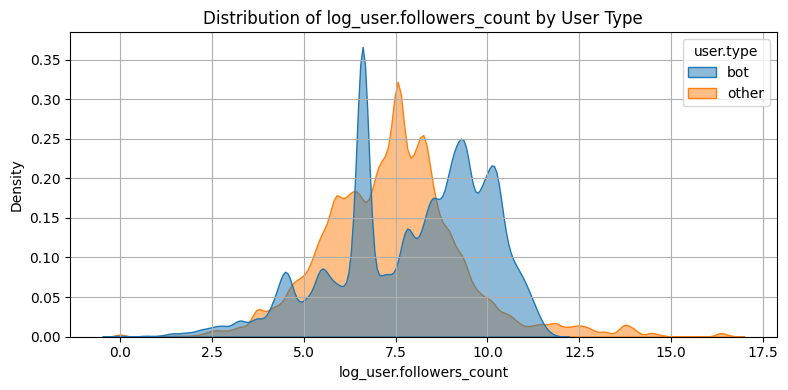

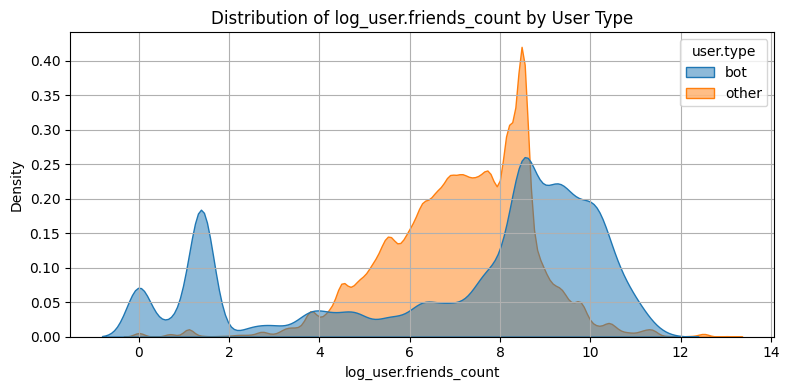

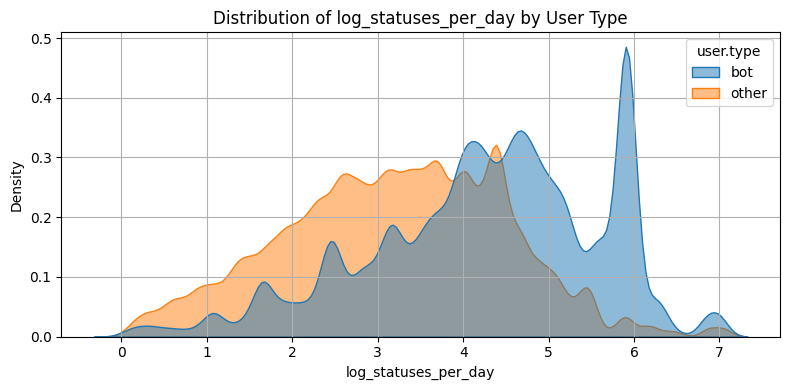

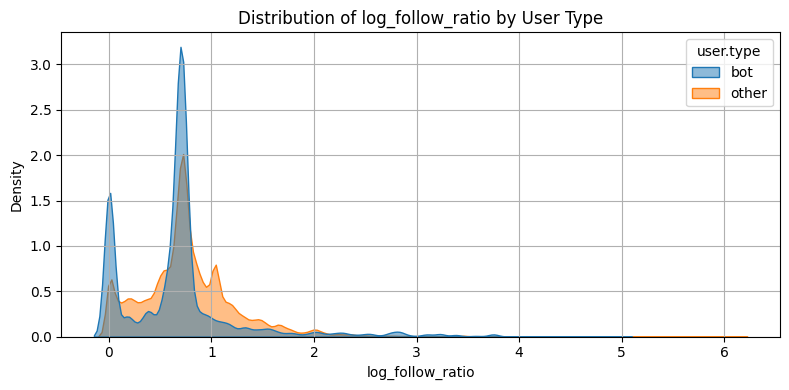

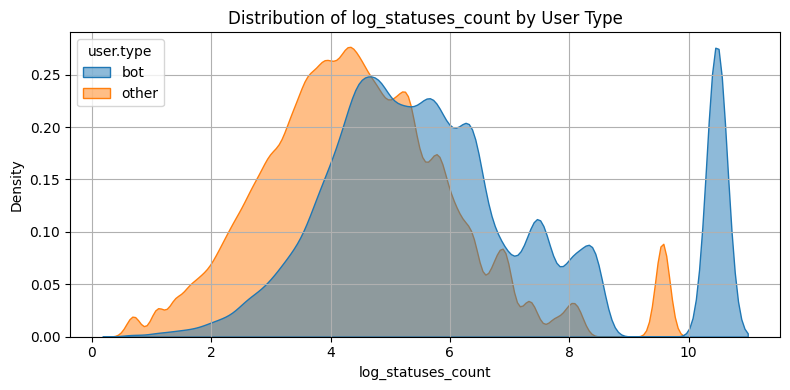

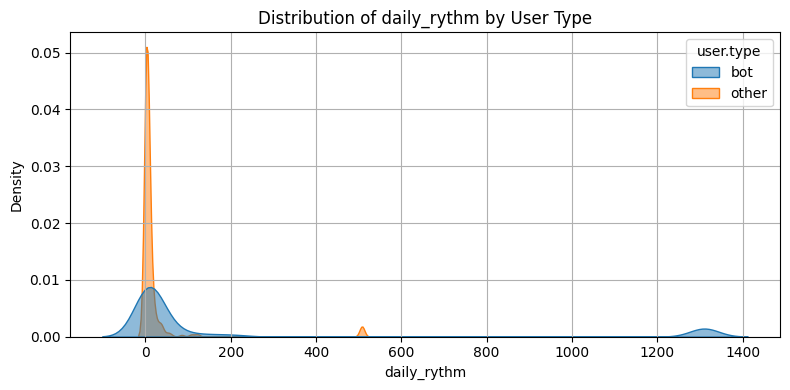

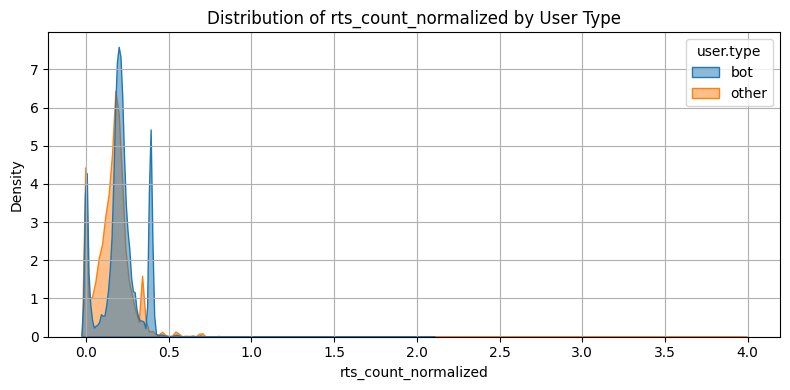

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

labeled_df = features_df.merge(twitter_df[['user.id', 'user.type']], on='user.id')
labeled_df = labeled_df[labeled_df['user.type'].isin(['bot', 'other'])]


features_to_plot = [
    "log_user.followers_count",
    "log_user.friends_count",
    "log_statuses_per_day",
    "log_follow_ratio",
    "log_statuses_count",
    "daily_rythm",
    "rts_count_normalized"
]


for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=labeled_df, x=feature, hue='user.type', fill=True, common_norm=False, alpha=0.5)
    plt.title(f"Distribution of {feature} by User Type")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# Drop user.id and keep it separately
user_ids = features_df["user.id"]
X = features_df.drop(columns=["user.id"])

# Z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# **K means**

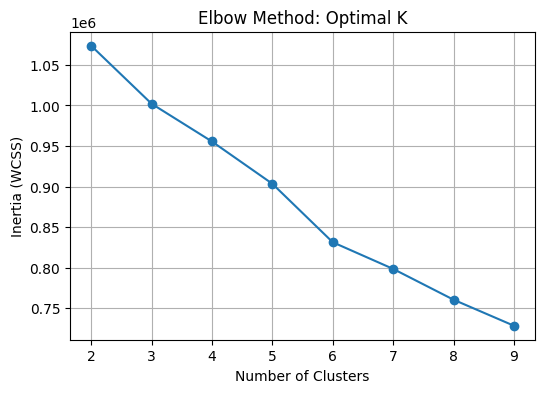

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


inertias = []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)


plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method: Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (WCSS)")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)


cluster_df = pd.DataFrame({
    "user.id": features_df["user.id"],
    "cluster": cluster_labels
})


In [ ]:

cluster_summary_df = cluster_df.merge(
    twitter_df[["user.id", "user.type"]],
    on="user.id",
    how="left"
)


cluster_counts = cluster_summary_df.groupby(["cluster", "user.type"]).size().unstack(fill_value=0)


cluster_counts["Total"] = cluster_counts.sum(axis=1)


print(cluster_counts)


user.type     bot   other  unknown    Total
cluster                                    
0             942   22023    29697    52662
1            1933   20081    26532    48546
2          153900  382192   477967  1014059
3            4938   31560    41541    78039
4          131265   84612   113016   328893


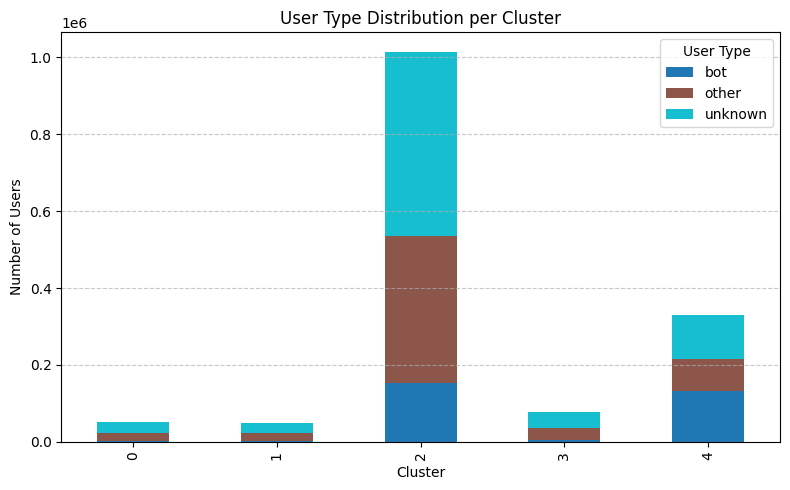

In [ ]:
import matplotlib.pyplot as plt


cluster_counts[["bot", "other", "unknown"]].plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    colormap="tab10"
)

plt.title("User Type Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Users")
plt.legend(title="User Type")
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
labeled_eval_df = cluster_df.merge(
    twitter_df[["user.id", "user.type"]],
    on="user.id",
    how="left"
)

labeled_eval_df = labeled_eval_df[labeled_eval_df["user.type"].isin(["bot", "other"])]


In [ ]:
counts = labeled_eval_df.groupby(["cluster", "user.type"]).size().unstack(fill_value=0)
counts["total"] = counts.sum(axis=1)
counts["%bot"] = (counts["bot"] / counts["total"]).round(4) * 100
counts["%human"] = (counts["other"] / counts["total"]).round(4) * 100

In [ ]:
def classify_cluster(row, bot_thresh=60, human_thresh=60):
    if row["%bot"] >= bot_thresh:
        return "bot_cluster"
    elif row["%human"] >= human_thresh:
        return "human_cluster"
    else:
        return "mixed_cluster"

counts["cluster_type"] = counts.apply(classify_cluster, axis=1)

In [ ]:
print(counts[["bot", "other", "total", "%bot", "%human", "cluster_type"]])

user.type     bot   other   total   %bot  %human   cluster_type
cluster                                                        
0             942   22023   22965   4.10   95.90  human_cluster
1            1933   20081   22014   8.78   91.22  human_cluster
2          153900  382192  536092  28.71   71.29  human_cluster
3            4938   31560   36498  13.53   86.47  human_cluster
4          131265   84612  215877  60.81   39.19    bot_cluster


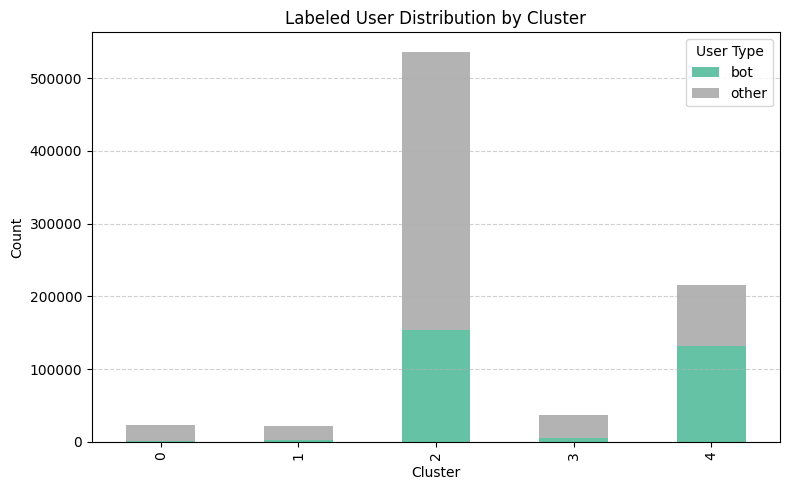

In [ ]:
import matplotlib.pyplot as plt

counts[["bot", "other"]].plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    colormap="Set2"
)

plt.title("Labeled User Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="User Type")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
cluster_type_map = counts["cluster_type"].to_dict()

cluster_df["cluster_type"] = cluster_df["cluster"].map(cluster_type_map)

cluster_df["predicted_user_type"] = cluster_df["cluster_type"].apply(lambda x: 1 if x == "bot_cluster" else 0)


In [ ]:
twitter_df=pd.read_csv(csv_path)

/tmp/ipython-input-69-2939465974.py:1: DtypeWarning: Columns (9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  twitter_df=pd.read_csv(csv_path)


In [ ]:
twitter_df_with_preds = twitter_df.merge(
    cluster_df[["user.id", "predicted_user_type"]],
    on="user.id",
    how="left"
)

twitter_df_with_preds["predicted_user_type"] = twitter_df_with_preds["predicted_user_type"].fillna(0).astype(int)


In [ ]:
botometer_df = pd.read_csv("/content/drive/MyDrive/Nour/twitter/Botometer_classified_posts.csv")


In [ ]:
botometer_df.head()

,id,post_type
0,1267443579045232651,bot
1,1267520253904510976,bot
2,1267587387443593217,bot
3,1267840580299694082,bot
4,1267887896884908032,bot


In [ ]:
# Rename predicted column for clarity
twitter_df_with_preds = twitter_df_with_preds.rename(columns={"post_id": "id"})

In [ ]:
twitter_df_with_preds.columns

Index(['id', 'text', 'created_at', 'lang', 'entities.urls',
       'entities.user_mentions', 'entities.hashtags', 'user.id',
       'user.description', 'user.location', 'user.name', 'user.screen_name',
       'user.url', 'user.protected', 'user.verified', 'user.followers_count',
       'user.friends_count', 'user.listed_count', 'user.favourites_count',
       'user.statuses_count', 'user.created_at',
       'user.profile_image_url_https', 'user.default_profile',
       'user.default_profile_image', 'is_retweet', 'is_quote', 'is_reply',
       'in_reply_to_user_id', 'in_reply_to_status_id', 'quote.id',
       'quote.user.id', 'rt.id', 'rt.user.id', 'user.type',
       'predicted_user_type'],
      dtype='object')

In [ ]:


merged_eval = botometer_df.merge(
    twitter_df_with_preds[["id", "predicted_user_type"]],
    on="id",
    how="inner"
)


In [ ]:
merged_eval.head()

,id,post_type,predicted_user_type
0,1267443579045232651,bot,1
1,1267520253904510976,bot,1
2,1267587387443593217,bot,1
3,1267840580299694082,bot,1
4,1267887896884908032,bot,1


In [ ]:
merged_eval['post_type'].unique()

array(['bot', 'deleted', 'suspended', 'other'], dtype=object)

In [ ]:
merged_eval["post_type"] = merged_eval["post_type"].apply(
    lambda x: 1 if str(x).strip().lower() == "bot" else 0
)


In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(
    merged_eval["post_type"],
    merged_eval["predicted_user_type"]
)

print(f"Cohen's Kappa agreement score: {kappa:.4f}")


Cohen's Kappa agreement score: 0.2949


# **Agglomerative**

In [ ]:
from sklearn.cluster import AgglomerativeClustering


agglo = AgglomerativeClustering(n_clusters=5)
cluster_labels = agglo.fit_predict(X_scaled)


cluster_df = pd.DataFrame({
    "user.id": features_df["user.id"],
    "cluster": cluster_labels
})


In [ ]:

agglo_labeled = cluster_df.merge(twitter_df[["user.id", "user.type"]], on="user.id", how="left")
agglo_labeled = agglo_labeled[agglo_labeled["user.type"].isin(["bot", "other"])]


agglo_counts = agglo_labeled.groupby(["cluster", "user.type"]).size().unstack(fill_value=0)
agglo_counts["total"] = agglo_counts.sum(axis=1)
agglo_counts["%bot"] = (agglo_counts["bot"] / agglo_counts["total"]) * 100
agglo_counts["%human"] = (agglo_counts["other"] / agglo_counts["total"]) * 100


In [ ]:
def classify_cluster(row, bot_thresh=50, human_thresh=60):
    if row["%bot"] >= bot_thresh:
        return "bot_cluster"
    elif row["%human"] >= human_thresh:
        return "human_cluster"
    else:
        return "mixed_cluster"

agglo_counts["cluster_type"] = agglo_counts.apply(classify_cluster, axis=1)

cluster_type_map = agglo_counts["cluster_type"].to_dict()


In [ ]:
cluster_type_map

{0: 'human_cluster',
 1: 'human_cluster',
 2: 'human_cluster',
 3: 'mixed_cluster',
 4: 'human_cluster'}

In [ ]:
cluster_df["cluster_type"] = cluster_df["cluster"].map(cluster_type_map)
cluster_df["predicted_user_type"] = cluster_df["cluster_type"].apply(lambda x: 1 if x == "bot_cluster" else 0)


In [ ]:

twitter_df_with_agglo = twitter_df.merge(
   cluster_df[["user.id", "predicted_user_type"]],
    on="user.id",
    how="left"
)


twitter_df_with_agglo["predicted_user_type"] = twitter_df_with_agglo["predicted_user_type"].fillna(0).astype(int)


In [ ]:

merged_eval.columns

Index(['id', 'post_type', 'predicted_user_type'], dtype='object')

In [ ]:



merged_eval = botometer_df.merge(
    twitter_df_with_agglo[["id", "predicted_user_type"]],
    on="id",
    how="inner"
)

merged_eval["post_type"] = merged_eval["post_type"].apply(lambda x: 1 if str(x).strip().lower() == "bot" else 0)


from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(merged_eval["post_type"], merged_eval["predicted_user_type"])

print(f"Cohen’s Kappa Agreement Score (Agglomerative): {kappa:.4f}")


Cohen’s Kappa Agreement Score (Agglomerative): 0.0000


# **DBSCAN**

In [ ]:
user_ids = features_df["user.id"]

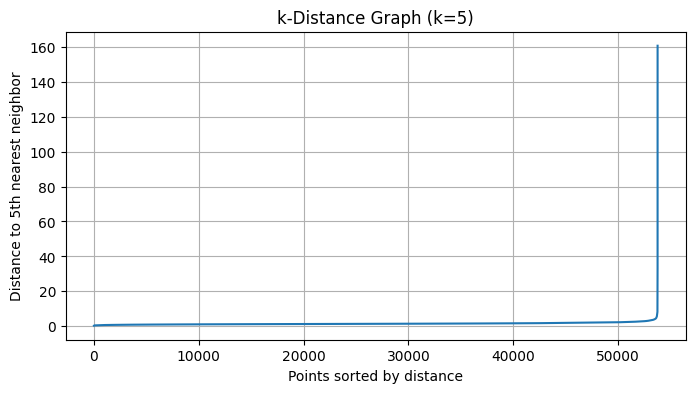

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt


k = 5
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)


k_distances = np.sort(distances[:, k - 1])


plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title(f"k-Distance Graph (k={k})")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.grid(True)
plt.show()


In [ ]:
len(twitter_df)

1522199

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3, min_samples=60)
db_labels = dbscan.fit_predict(X_scaled)

db_df = pd.DataFrame({
    "user.id": user_ids,
    "dbscan_label": db_labels
})

db_df["predicted_user_type"] = db_df["dbscan_label"].apply(lambda x: 1 if x == -1 else 0)


In [ ]:
twitter_df_with_dbscan = twitter_df.merge(
    db_df[["user.id", "predicted_user_type"]],
    on="user.id",
    how="left"
)

twitter_df_with_dbscan["predicted_user_type"] = twitter_df_with_dbscan["predicted_user_type"].fillna(0).astype(int)

In [ ]:
twitter_df_with_dbscan = twitter_df_with_dbscan.rename(columns={"post_id":"id"})

In [ ]:
botometer_df = pd.read_csv("/content/drive/MyDrive/Nour/twitter/Botometer_classified_posts.csv")


merged_eval = botometer_df.merge(
    twitter_df_with_dbscan[["id", "predicted_user_type"]],
    on="id",
    how="inner"
)

merged_eval["post_type"] = merged_eval["post_type"].apply(lambda x: 1 if str(x).strip().lower() == "bot" else 0)


In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(
    merged_eval["post_type"],
    merged_eval["predicted_user_type"]
)

print(f"Cohen’s Kappa agreement score (DBSCAN): {kappa:.4f}")


Cohen’s Kappa agreement score (DBSCAN): 0.2381
